This excercise is direct implementation of excercise2 of week1 - Coursera course - Machine learning by Andrew Ng. Actual course implementation is in Octave, I have tried this implemetation in Systemml on Spark running on Yarn. 

Step 1. 
-----------------------------------------------------------------------
Import required libraries for Systemml, Spark and Matplotlib

We have already configured pyspark to kick-start jupyter notebook, hence spark context as "spark" is already created for us and required core spark libraries are already imported. Hence there is no need to import "Context", "Session" and all that stuff.

In [1]:
import systemml as sml
from systemml import MLContext, dml,  dmlFromFile
import numpy as np
from pyspark.sql.types import *
import matplotlib.pyplot as plt

Step 2.
---------------------
Create context for Systemml from spark. This step sets up environment for systemml execution on spark. We also setip matplotlib to create inline graphs

In [2]:
ml = MLContext(spark)
%matplotlib inline

In [3]:
schema = StructType([ StructField("sft", FloatType(), True),
                     StructField("br", FloatType(), True),
                     StructField("price", FloatType(), True)])
ex1_data = spark.read.csv("ex1/ex1data2.txt",schema)

Step 3.
-----------------------------------
Initialize required data for regression. These are:-
* X: Input vector [1,squarefeet , No. of bedrooms].
* y: Output vector
* Theta: Solution weights initialized to 0
* m: Number of input samples i.e rows.


In [4]:
# In ML indexing starts at 1 not 0.
#Note theta is initialize to number of rows one more than are features in X. This is to accomodate for intercept term
#which will be added to X in the next step.
sml_initialize = """
    ncols = ncol(ex1_data1)
    X = as.matrix(ex1_data1[,1:ncols-1])
    y = as.matrix(ex1_data1[,ncols])
    m = nrow(ex1_data1)
    theta = matrix(0,ncol(X)+1,1)
"""
#Below two statements execute systemml script defined above on spark with the inputs you provide and 
#returns defined outputs
sml_init_script = dml(sml_initialize).input(ex1_data1=ex1_data).output("X","y","m","theta","ncols")
X,y,m,theta,nc = ml.execute(sml_init_script).get("X","y","m","theta","ncols")

SystemML Statistics:
Total execution time:		0.725 sec.
Number of executed Spark inst:	0.




Step 4.
------------------------
Normalize X ax (X - mean(X))/Sd(X).  
Add feature vector for intercept term to X i.e pad one(nrows)  to X.

In [5]:
sml_normalizeX = """
    X_means = colMeans(X)
    X_sds = colSds(X)
    X = (X - X_means)/X_sds
    m = nrow(X)
    ones = matrix(1,m,1)
    X = cbind(ones,X)
"""

sml_normalize_script = dml(sml_normalizeX).input(X=X).output("X","X_means", "X_sds")
script_result = ml.execute(sml_normalize_script)
X_normalized,X_mean, X_sd= script_result.get("X","X_means", "X_sds")

SystemML Statistics:
Total execution time:		0.171 sec.
Number of executed Spark inst:	0.




Step 5.
------------------
Convert ML matrices to numpy arrays for plotting

In [6]:
X_n = X.toNumPy()
y_n = y.toNumPy()
theta_n = theta.toNumPy()

Step 6.
------------------
Plot price againist square-feet and number of bedrooms. If you plot these against normalized data(X_normalized) you will see that the range of X is between some small -ve number to +ve number

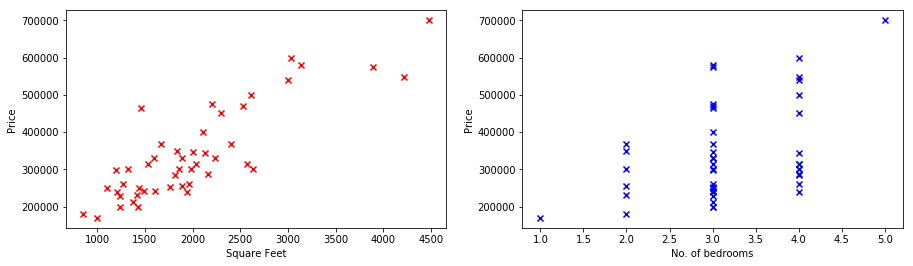

In [8]:
plt.figure()
plt.subplot(121)
plt.scatter(X_n[:,0],y_n,color='red',marker='x')
plt.ylabel('Price')
plt.xlabel('Square Feet')
plt.subplot(122)
plt.scatter(X_n[:,1],y_n,color='blue',marker='x')
plt.ylabel('Price')
plt.xlabel('No. of bedrooms')
plt.rcParams["figure.figsize"] = (15,4)
plt.show()

Step 7.
-------------------
Define ML script for CostFunction and Gradient Descent. In gradient descent function we store all values of cost and theta. Cost values are plotted later in the notebook. 

"sml_cost" and compute_cost functions in below block is redundant, I included it here just to have completeness w.r.t octave implementation on the course.  

Correct way to do this is to create Systemmml functions in the script and then use it over here.  But this usecase I will explore in some later excercise.

In [9]:
sml_cost = """
    m = nrow(y)
    J = as.matrix(sum((X %*% theta - y)^2)/(2*m))
    """

sml_gd = """
    m = nrow(y)
    theta_hist = matrix(0,ncol(X),1)
    J = as.matrix(sum((X %*% theta - y)^2)/(2*m))
    for (iter in 1:num_iters) {
        theta =  theta - t(((t(X %*% theta -y)) %*% X)*(alpha/m))
        J = rbind(J,as.matrix(sum((X %*% theta - y)^2)/(2*m)))
        theta_hist = rbind(theta_hist,theta)
    }
    """

def compute_cost(X,y,theta):
    sml1_script = dml(sml_cost).input(X=X,y=y,theta=theta).output("J")
    return  ml.execute(sml1_script).get("J")

def gradient_descent(X, y, theta, alpha, num_iters=50):
    sml_script = dml(sml_gd).input(X=X,y=y,theta=theta,alpha=alpha,num_iters=num_iters).output("theta","J")
    return  ml.execute(sml_script).get("theta","J")

Step 8.
--------------
Calculate weights and cost for our data X_normalized and y for alpha 0.1 [0.3].

In [10]:
theta_f, J_all = gradient_descent(X_normalized, y, theta, alpha=0.1)
theta_f_03, J_all_03 = gradient_descent(X_normalized, y, theta, alpha=0.3)

SystemML Statistics:
Total execution time:		1.041 sec.
Number of executed Spark inst:	0.


SystemML Statistics:
Total execution time:		0.710 sec.
Number of executed Spark inst:	0.




Weights calculated for alpha 0.1 and 0.3
---------------------------

In [11]:
print "Theta for alplha 0.1\n"
print theta_f.toNumPy()

print "\nTheta for alplha 0.3\n"
print theta_f_03.toNumPy()

Theta for alplha 0.1

[[ 3.38658249e+05]
 [ 1.04127516e+05]
 [-1.72205334e+02]]

Theta for alplha 0.3

[[340412.65345227]
 [110572.96193087]
 [ -6591.38592285]]


Step 9.
-------------------
Predict the price of 3 bedroom house having 1650 sqft. area. First step is to map this input to the mean and SD we used on input training data. 
Once transformed , multiply by respective theta values to get predicted house price

In [12]:
x_predict = ([1650,3] - X_mean.toNumPy())/X_sd.toNumPy()
p = np.sum([1,x_predict[0][0],x_predict[0][1]] * np.transpose(theta_f.toNumPy()))
print "House price calculated for alpha 0.1\t",p
p =  np.sum([1,x_predict[0][0],x_predict[0][1]] * np.transpose(theta_f_03.toNumPy()))
print "House price calculated for alpha 0.3\t",p

House price calculated for alpha 0.1	292748.0852321537
House price calculated for alpha 0.3	293094.09812181717


Step 10.
---------------------
Plot Cost values for alpha 0.1 and 0.3 by first converting these to numpy arrays.

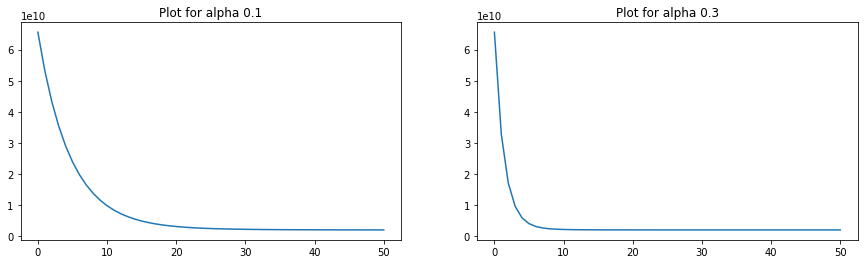

In [14]:
J_n = J_all.toNumPy()
J_03_n = J_all_03.toNumPy()
plt.figure(2)
plt.subplot(121)
plt.plot(J_n)
plt.title("Plot for alpha 0.1")
plt.subplot(122)
plt.plot(J_03_n)
plt.title("Plot for alpha 0.3")
plt.rcParams["figure.figsize"] = (15,4)
plt.show()